In [4]:
from recognition import *

import matplotlib.pyplot as plt
from segmentation import predict
import cv2

from utils.cluster_points import hcluster, mean_cluster
from utils.geometry import angle_between, angle_diff

import numpy as np

from utils.image_manipulation import *

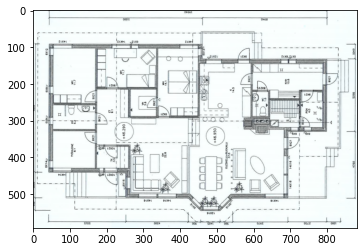

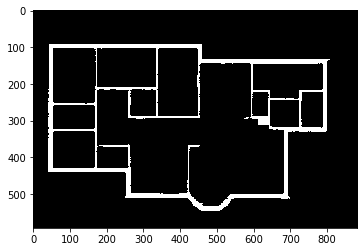

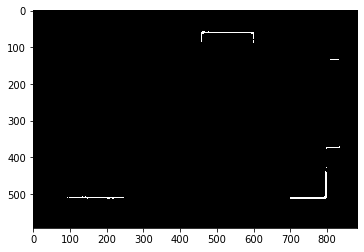

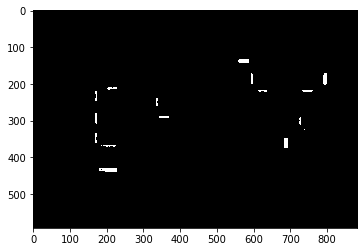

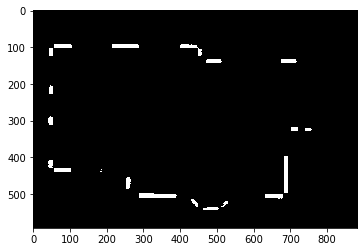

In [5]:
original = cv2.imread('./original.png')
# original = cv2.imread('../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/22/F1_original.png')
# original = cv2.imread('../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2504/F1_original.png')
rooms_pred, icons_pred, heatmaps = predict(original)

plt.imshow(original)
plt.show()

# Structural elements
walls_closed = as_image(rooms_pred == 2)
plt.imshow(walls_closed, cmap='gray', interpolation='none')
plt.show()

railing_pixels = as_image(rooms_pred == 8)
plt.imshow(railing_pixels, cmap='gray', interpolation='none')
plt.show()

doors_pixels = as_image(icons_pred ==  2)
plt.imshow(doors_pixels, cmap='gray', interpolation='none')
plt.show()

windows_pixels = as_image(icons_pred ==  1)
plt.imshow(windows_pixels, cmap='gray', interpolation='none')
plt.show()
# Decorative elements
closets_pixels = as_image(icons_pred == 3)
toilets_pixels = as_image(icons_pred == 5)
sinks_pixels = as_image(icons_pred == 6)
bathtubs_pixels = as_image(icons_pred == 9)
##

In [6]:
def wall_to_poly(wall, width):
    """Generates the vertices to a given wall with two endpoints and a width."""
    v = wall[1] - wall[0]
    p = np.array([v[1], -v[0]])
    p = p / np.linalg.norm(p)

    p1 = wall[0] + p*(width/2)
    p2 = p1 + v
    p3 = p2 - p*width
    p4 = p3 - v

    return np.array([p1, p2, p3, p4])

def warp_fitness(wall, wall_pixels, width, verbose_threshold):

    length = np.linalg.norm(wall[1] - wall[0])
    rect = wall_to_poly(wall, width)
    src = np.float32(rect[:3,:])
    dest = np.float32([[0, 0], [length, 0], [length, width]])
    M = cv2.getAffineTransform(src, dest)
    new_img = cv2.warpAffine(wall_pixels, M, (wall_pixels.shape[1], wall_pixels.shape[0]), cv2.INTER_NEAREST)
    new_img = cv2.getRectSubPix(new_img, np.intp([length, width]), (length//2, width//2))

    n_horizontal_pixels = np.sum(np.sum(new_img, axis=0) > 0)
    ratio = n_horizontal_pixels/new_img.shape[1]

    if ratio > verbose_threshold:
        # fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        fig, axes = plt.subplots(1, 2)
        axes[0].imshow(wall_pixels, cmap='gray', interpolation='none')
        axes[0].plot(wall[0,0], wall[0,1], color='red', marker='o', markersize=10)
        axes[0].plot(wall[1,0], wall[1,1], color='red', marker='o', markersize=10)

        axes[1].imshow(new_img, cmap='gray', interpolation='none')

        fig.tight_layout()
        plt.show()

        print(ratio)
    return ratio

def fitness(wall, wall_pixels, width):
    new_image = np.zeros(wall_pixels.shape)
    rect = wall_to_poly(wall, width)
    new_image = np.int0(cv2.fillConvexPoly(new_image, points = np.array(rect, dtype=np.int32), color = 255))//255

    i = np.sum(new_image & wall_pixels)
    total = np.sum(new_image)
    ratio = i/total
    return ratio

def get_junctions(heatmaps, wall_pixels, junction_threshold, multiply_maps):
    wall_heatmaps = heatmaps[:13]
    junctions = wall_heatmaps.sum(axis=0)
    if multiply_maps:
        junctions *= wall_pixels


    plt.imshow(junctions, interpolation='none')
    plt.show()
    print('='*12)
    junctions = np.where(junctions > junction_threshold, 1, 0)

    plt.imshow(junctions, interpolation='none')
    plt.show()
    print('='*12)

    contours, _ = cv2.findContours(junctions.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    centroids = []

    for c in contours:
        # Get the contours bounding rectangle:
        boundRect = cv2.boundingRect(c)

        # Get the centroid of the rectangle:
        cX = int(boundRect[0] + 0.5 * boundRect[2])
        cY = int(boundRect[1] + 0.5 * boundRect[3])
        centroids.append((cX, cY))

    return centroids

def normalize_points(all_points, distance_threshold):
    def sort_key(c):
        return (c[0], -c[1])

    allx = [p[0] for p in all_points]
    ally = [p[1] for p in all_points]

    xclusters = hcluster(allx, distance_threshold)
    xaverages = mean_cluster(xclusters[1])

    yclusters = hcluster(ally, distance_threshold)
    yaverages = mean_cluster(yclusters[1])

    res = []
    for px, py in all_points:
        px = xaverages[1][xclusters[0][px]]
        py = yaverages[1][yclusters[0][py]]

        res.append([px, py])

    with_original = zip(all_points, res)
    with_original = sorted(with_original, key=lambda p: sort_key(p[1]))
    original, normalized = [p[0] for p in with_original], [p[1] for p in with_original]
    return np.array(original).astype(np.intp), np.array(normalized).astype(np.intp)

def try_wall(c1, c2, o1, o2, wall_pixels, angles_put, angles_tried):
    angle = angle_between(c2 - c1, np.array([1, 0]))
    other_angle = angle_between(c1 - c2, np.array([1, 0]))
    if any(angle_diff(a, angle) < 5 for a in angles_tried[tuple(c1)]): # do not points that go over tried junctios
        return False

    # 70 yields best results for the primary school floor plan, but it's hammered in
    if (any(angle_diff(a, angle) < 70 for a in angles_put[tuple(c1)]) 
        or any(angle_diff(a, other_angle) < 70 for a in angles_put[tuple(c2)])): # do not add overlapping walls
        return False

    # We add this one immediatly because if not we could place a wall over two junction points, which
    # does not make sense
    angles_tried[tuple(c1)].add(angle)

    inter_threshold = 0.75
    inter = warp_fitness(np.array((o1, o2)), wall_pixels, 7, verbose_threshold=0)
    if inter > inter_threshold:
        # Do not allow a wall going back the same direction (might happen if its further on the x axis)
        angles_put[tuple(c1)].add(angle)
        angles_put[tuple(c2)].add(angle_between(c1 - c2, np.array([1, 0])))
        print(f'c2 - c1: {angle}, c1 - c2: {angle_between(c1- c2, np.array([1, 0]))}')
        print(angles_put[tuple(c2)])

        return True
    return False

def get_walls(heatmaps, wall_pixels, junction_threshold=0.2, distance_threshold=5, multiply_maps=True):
    junctions = get_junctions(heatmaps, wall_pixels//255, junction_threshold, multiply_maps)
    # junctions = get_junctions_cubi(heatmaps, wall_pixels//255, junction_threshold, int(np.sqrt(2*(distance_threshold**2))))
    originals, points = normalize_points(junctions, distance_threshold)

    walls = []

    angles_put = {tuple(p): set() for p in points}
    angles_tried = {tuple(p): set() for p in points}

    for i in range(len(points)-1):
        c1, o1 = points[i], originals[i]

        c2, o2 = points[i+1], originals[i+1]
        angle = angle_between(c2 - c1, np.array([1, 0]))
        if not np.array_equal(c1, c2) and abs(angle - 90) < 5: # check if vertical
            if try_wall(c1, c2, o1, o2, wall_pixels, angles_put, angles_tried):
                walls.append((c1, c2))

        # find next that is horizontal
        c2 = [x for x in zip(points[i+1:], originals[i+1:]) if not np.array_equal(c1, x[0]) and c1[1] == x[0][1]]
        if c2 != []:
            c2, o2 = c2[0]
            if try_wall(c1, c2, o1, o2, wall_pixels, angles_put, angles_tried):
                walls.append((c1, c2))

        for j in range(i+1, len(points)):
            c2, o2 = points[j], originals[j]
            if np.array_equal(c1, c2): # clustered points are ignored
                continue

            if try_wall(c1, c2, o1, o2, wall_pixels, angles_put, angles_tried):
                walls.append((c1, c2))

    return tuple(np.array(w).astype(np.float32) for w in walls)


# def get_junctions_cubi(heatmaps, wall_pixels, junction_threshold, gap):
#     wall_heatmaps = heatmaps[:13]
#     junctions = wall_heatmaps.sum(axis=0)# * wall_pixels

#     extracted = extract_local_max(junctions, junction_threshold,
#         close_point_suppression=True, gap=gap)

#     return extracted


# def extract_local_max(mask_img, heatmap_value_threshold,
#                       close_point_suppression=False, gap=10):
#     mask = mask_img.copy()
#     height, width = mask.shape
#     points = []

#     while True:
#         index = np.argmax(mask)
#         y, x = np.unravel_index(index, mask.shape)
#         max_value = mask[y, x]
#         if max_value <= heatmap_value_threshold:
#             return points

#         points.append(np.intp([x, y]))

#         maximum_suppression_iterative(mask, x, y, heatmap_value_threshold)
#         if close_point_suppression:
#             mask[max(y - gap, 0):min(y + gap, height - 1),
#                  max(x - gap, 0):min(x + gap, width - 1)] = -1

# def maximum_suppression_iterative(mask, x, y, heatmap_value_threshold):
#     height, width = mask.shape

#     stack = [(x, y)]
#     deltas = [(-1, 0), (1, 0), (0, -1), (0, 1)]

#     while len(stack) != 0:
#         x, y = stack.pop(0)
#         value = mask[y][x]
#         if value == -1:
#             continue
#         mask[y][x] = -1

#         for delta in deltas:
#             neighbor_x = x + delta[0]
#             neighbor_y = y + delta[1]
#             if neighbor_x < 0 or neighbor_y < 0 or neighbor_x >= width or neighbor_y >= height:
#                 continue

#             neighbor_value = mask[neighbor_y][neighbor_x]

#             if neighbor_value <= value and neighbor_value > heatmap_value_threshold:
#                 stack.append((neighbor_x, neighbor_y))

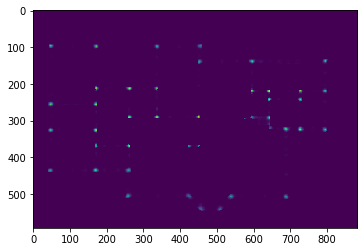

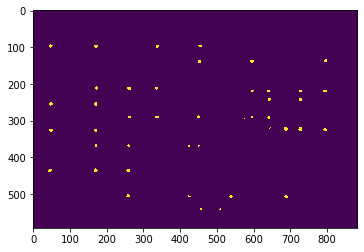

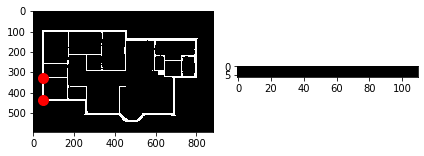

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{270.0}


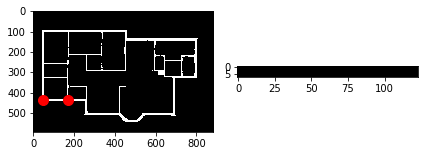

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


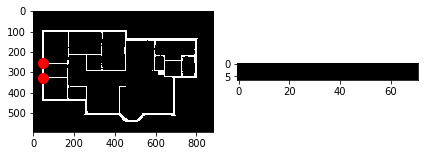

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{270.0}


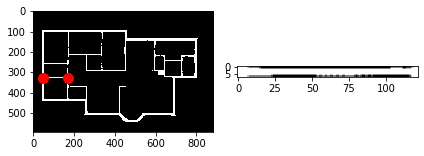

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


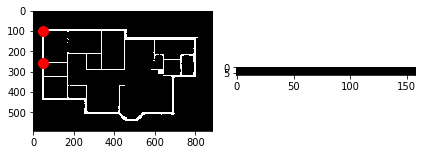

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{270.0}


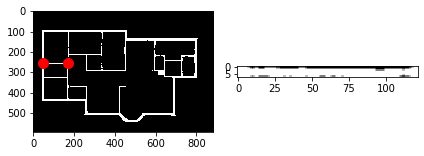

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


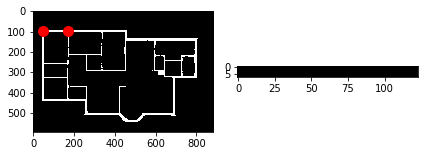

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


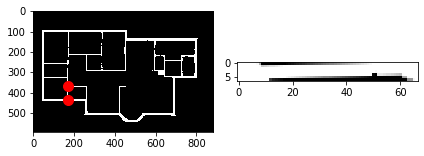

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{270.0}


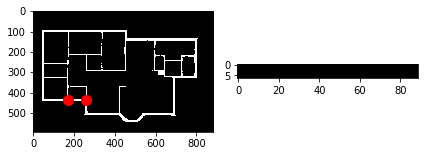

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


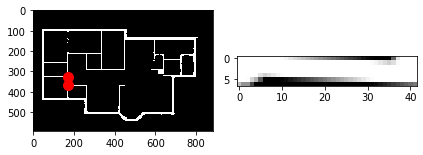

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{180.0, 270.0}


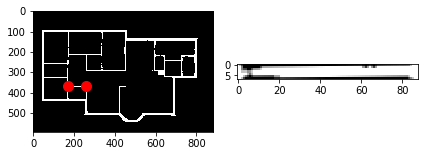

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


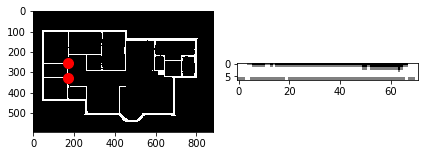

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{180.0, 270.0}


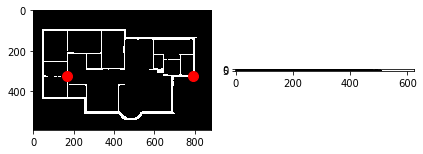

0.2520064205457464


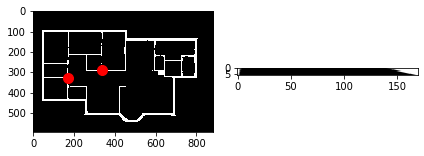

0.2647058823529412


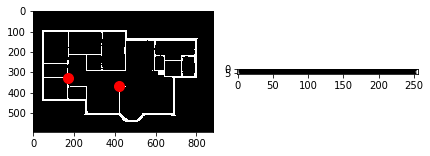

0.03125


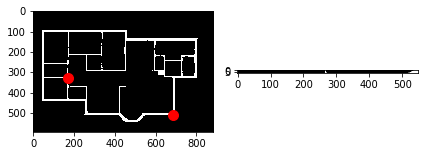

0.08409506398537477


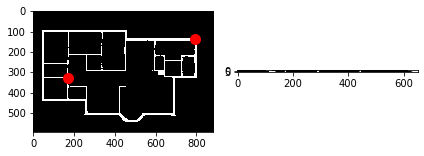

0.17972350230414746


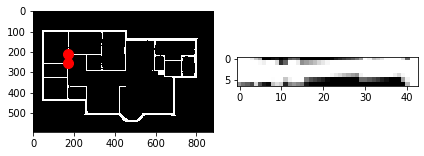

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{270.0}


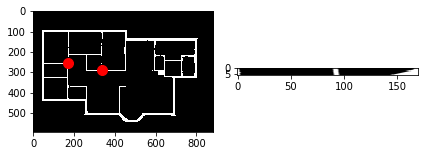

0.22941176470588234


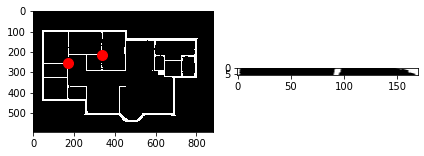

0.2411764705882353


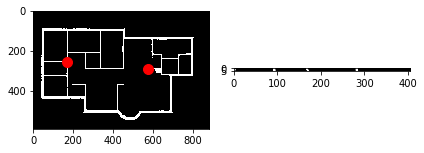

0.06666666666666667


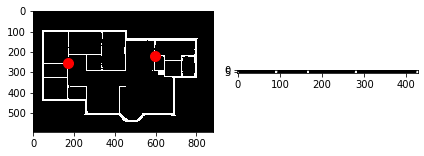

0.0702576112412178


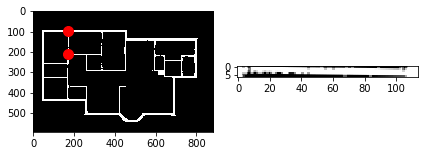

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{180.0, 270.0}


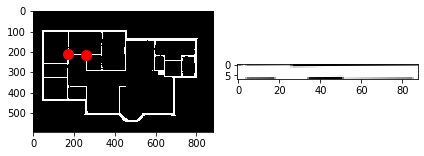

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


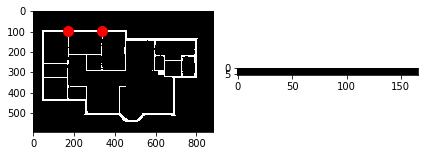

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


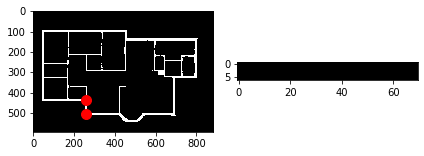

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{180.0, 270.0}


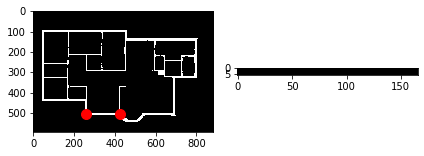

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


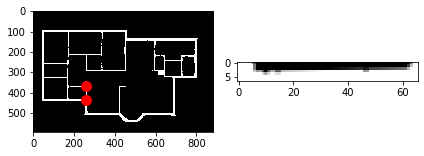

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{180.0, 270.0}


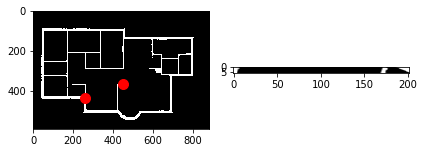

0.19801980198019803


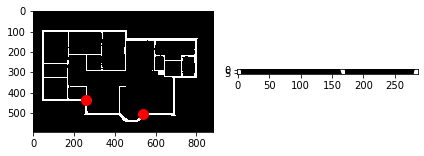

0.08013937282229965


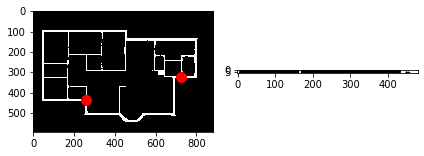

0.13333333333333333


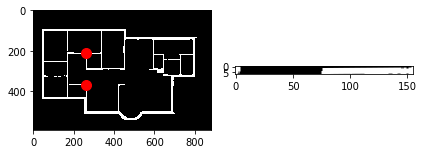

0.5512820512820513


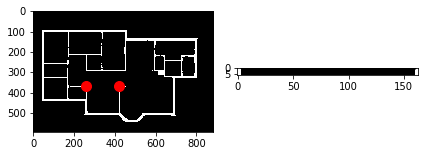

0.04294478527607362


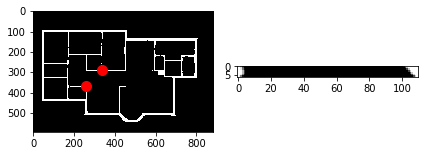

0.12727272727272726


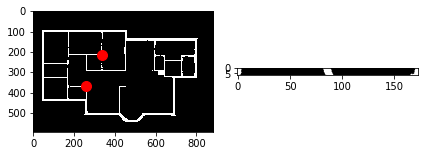

0.14450867052023122


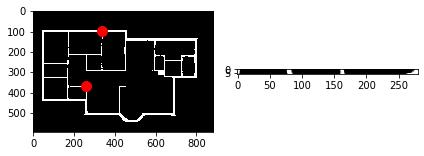

0.15357142857142858


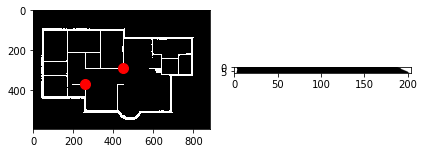

0.11274509803921569


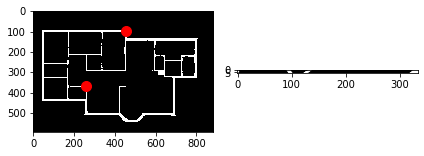

0.16167664670658682


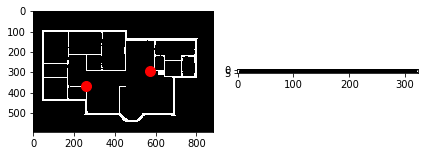

0.021671826625386997


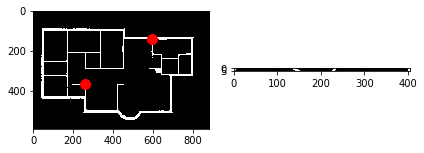

0.1259259259259259


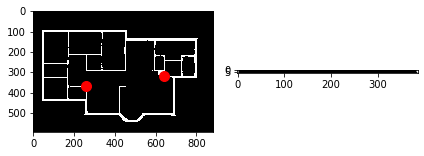

0.023316062176165803


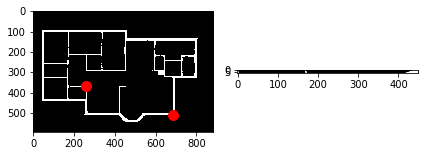

0.11607142857142858


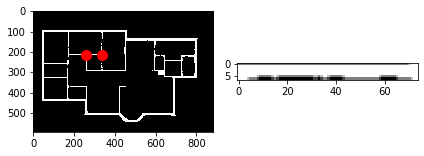

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


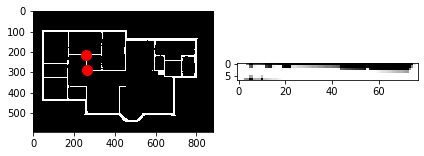

1.0
c2 - c1: 272.8985767992817, c1 - c2: 92.89857679928171
{92.89857679928171}


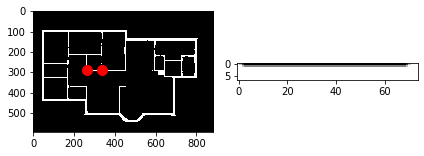

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


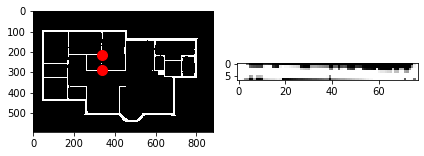

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{180.0, 270.0}


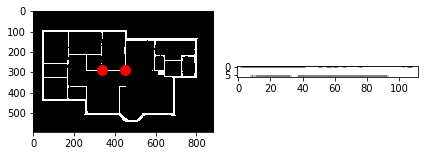

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


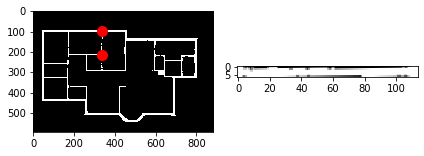

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{180.0, 270.0}


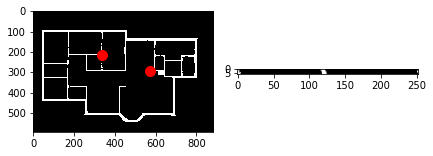

0.07936507936507936


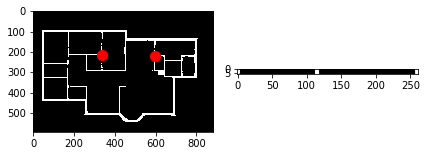

0.06896551724137931


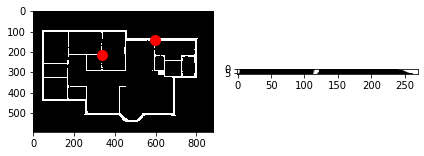

0.17407407407407408


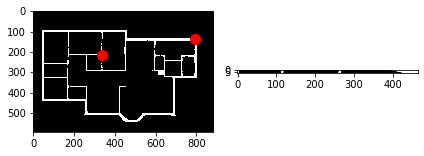

0.210752688172043


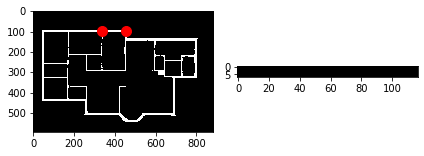

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


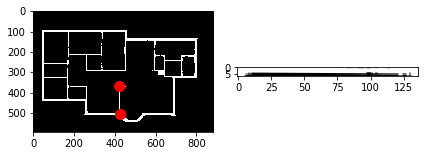

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{270.0}


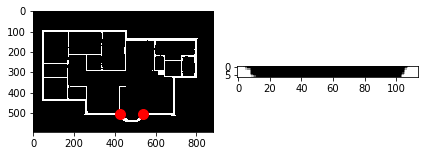

0.21052631578947367


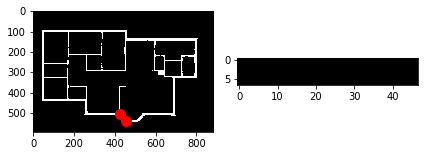

1.0
c2 - c1: 311.5317707410828, c1 - c2: 131.53177074108288
{131.53177074108288}


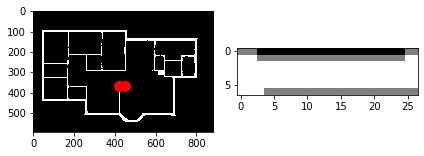

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


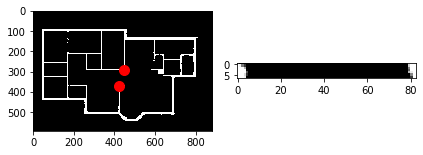

0.12048192771084337


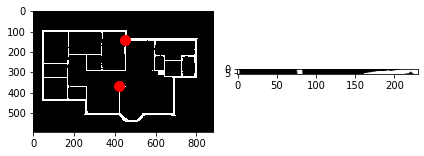

0.3652173913043478


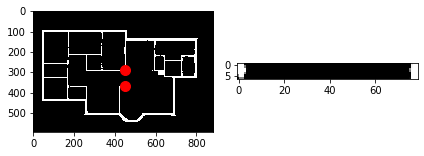

0.11392405063291139


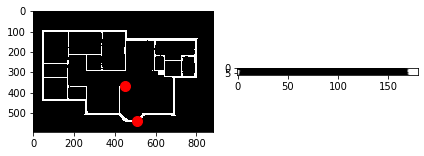

0.1


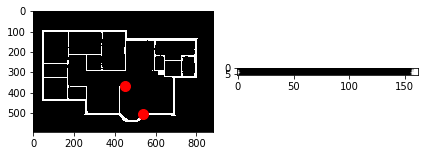

0.06790123456790123


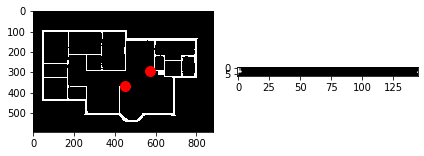

0.041379310344827586


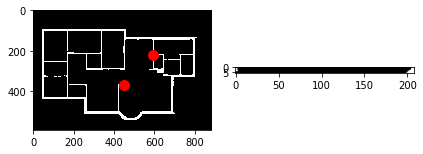

0.0673076923076923


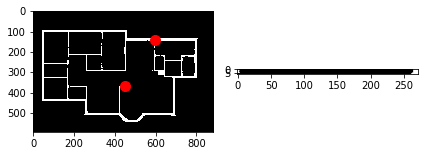

0.055350553505535055


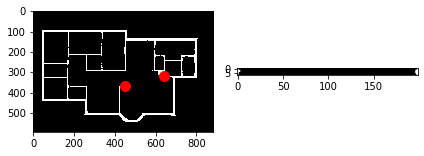

0.04020100502512563


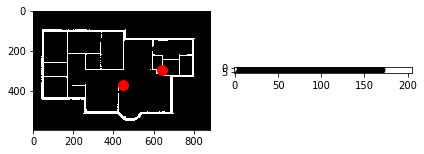

0.17560975609756097


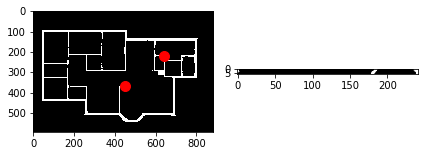

0.0954356846473029


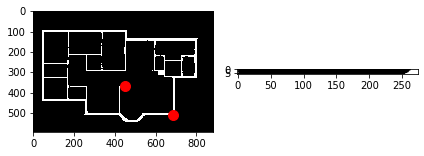

0.08759124087591241


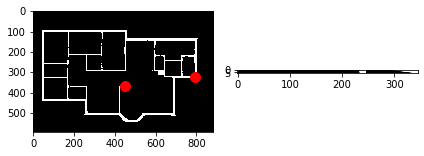

0.24347826086956523


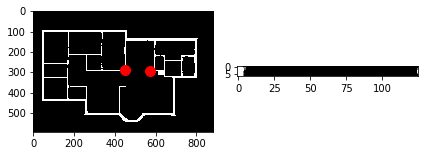

0.056


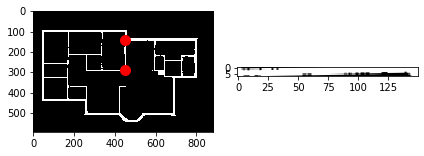

1.0
c2 - c1: 88.11594976890821, c1 - c2: 268.1159497689082
{268.1159497689082}


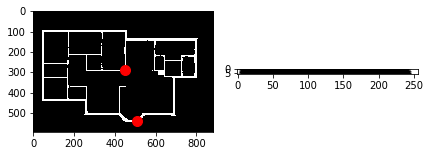

0.07421875


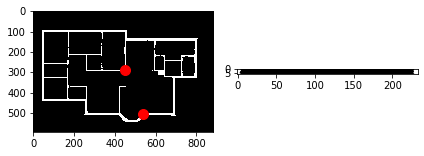

0.04721030042918455


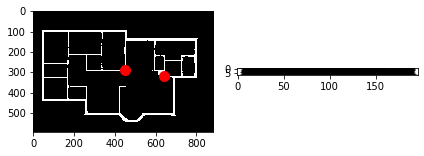

0.07142857142857142


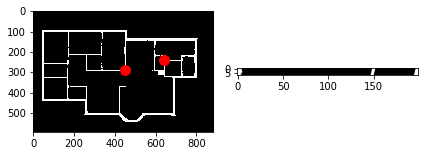

0.09045226130653267


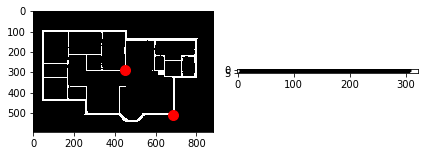

0.06521739130434782


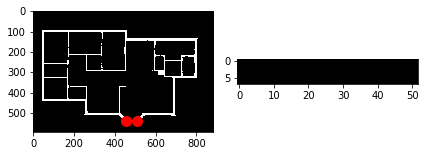

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


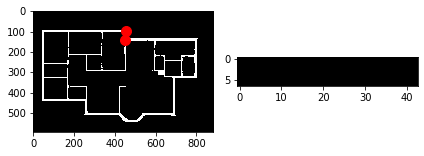

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{180.0, 270.0}


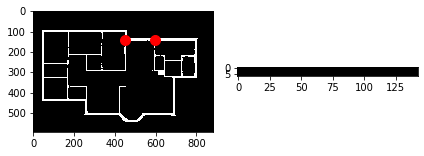

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


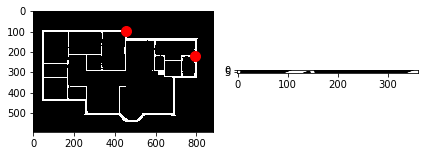

0.24722222222222223


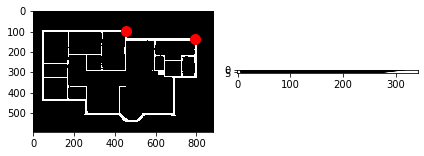

0.20760233918128654


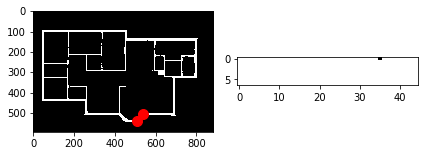

1.0
c2 - c1: 49.398705354995535, c1 - c2: 229.3987053549955
{229.3987053549955}


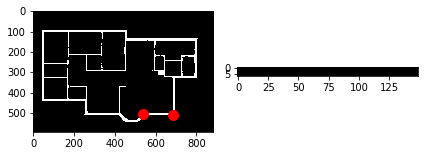

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


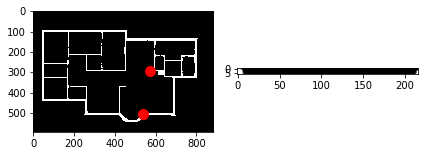

0.05092592592592592


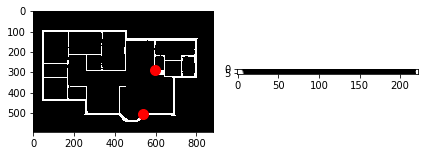

0.05405405405405406


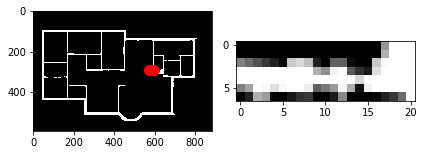

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


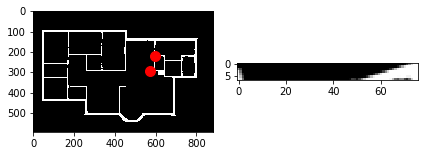

0.42105263157894735


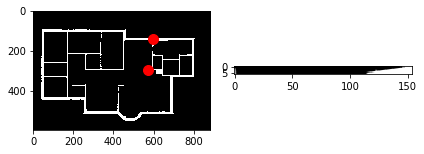

0.2792207792207792


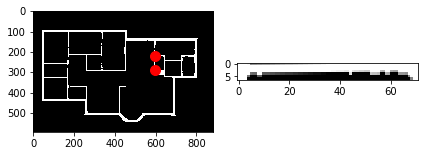

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{270.0}


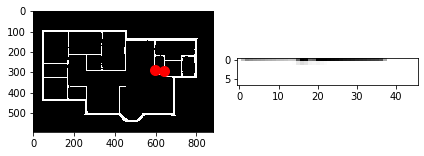

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


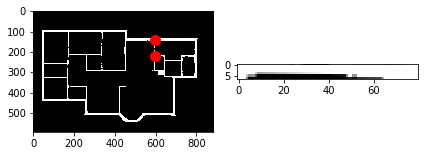

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{180.0, 270.0}


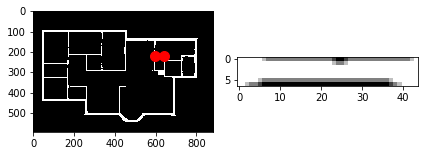

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


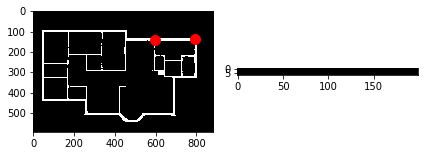

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


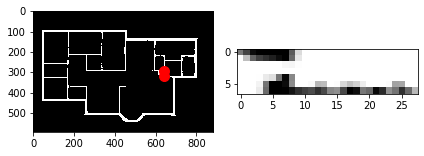

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{180.0, 270.0}


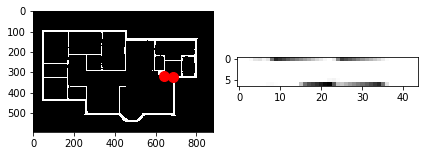

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


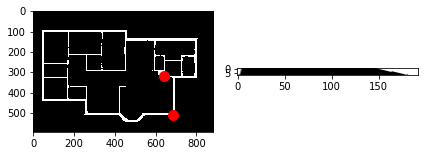

0.265625


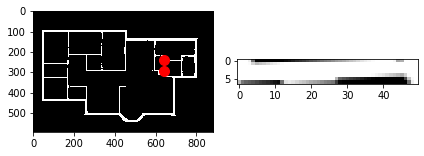

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{270.0}


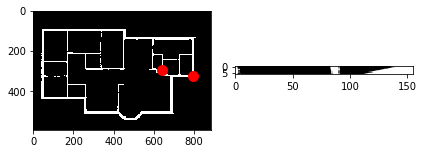

0.36774193548387096


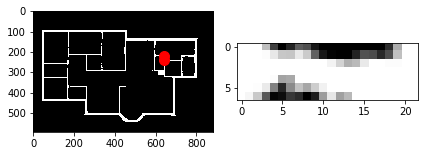

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{180.0, 270.0}


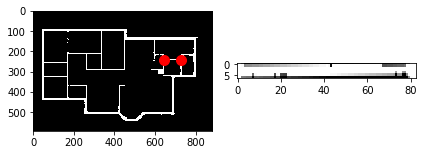

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


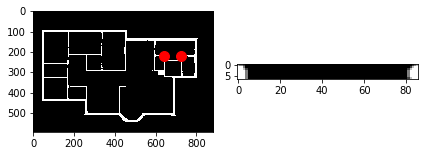

0.11627906976744186


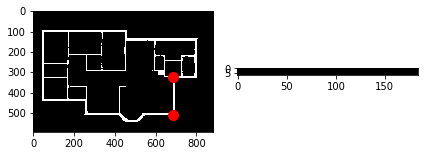

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{180.0, 270.0}


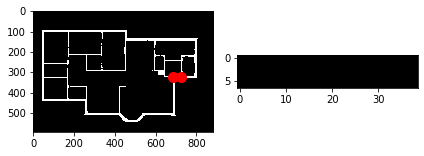

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


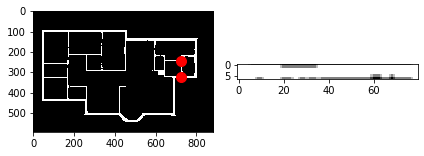

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{180.0, 270.0}


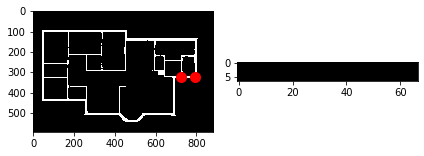

1.0
c2 - c1: 357.436229788535, c1 - c2: 177.436229788535
{177.436229788535}


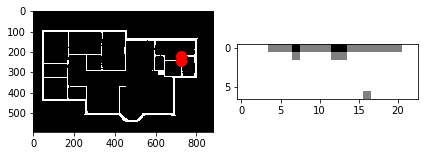

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{270.0}


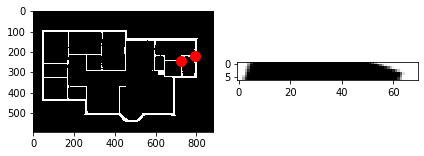

0.35714285714285715


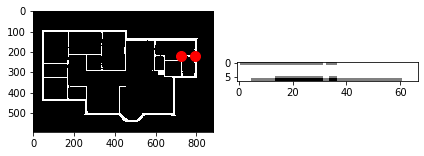

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


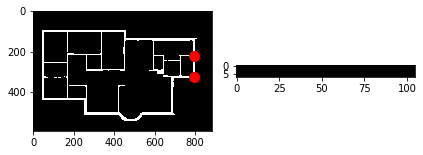

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{180.0, 270.0}


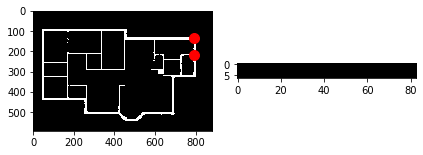

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{180.0, 270.0}


In [7]:
walls = get_walls(heatmaps, walls_closed, multiply_maps=True)
walls = tuple({'points': w} for w in walls)

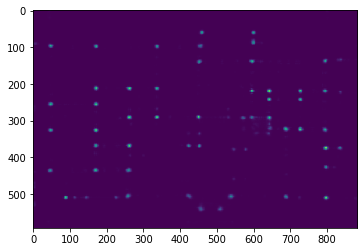

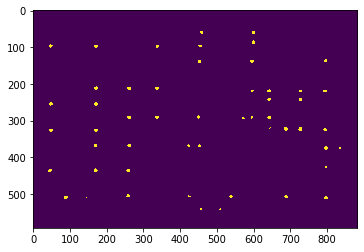

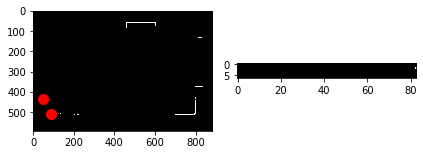

0.012048192771084338


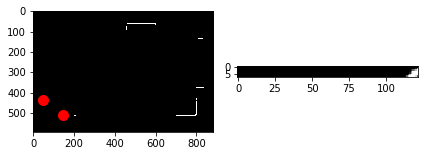

0.07377049180327869


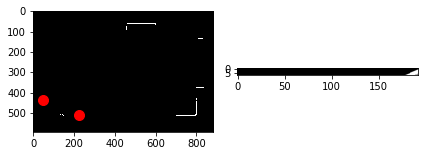

0.07291666666666667


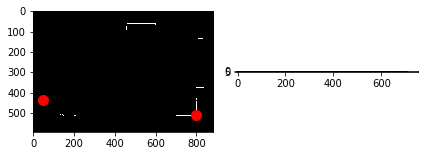

0.07446808510638298


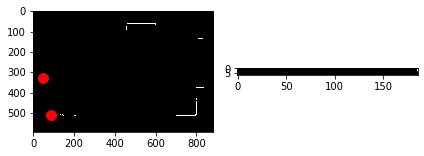

0.010752688172043012


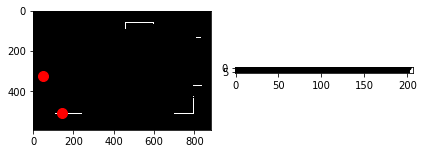

0.024154589371980676


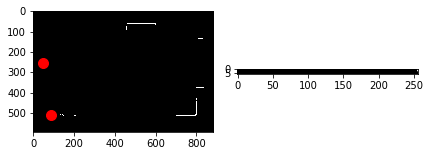

0.0078125


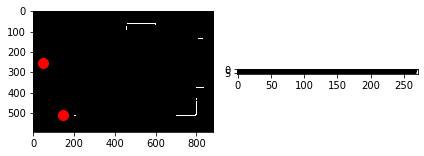

0.01107011070110701


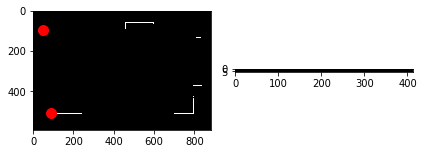

0.002421307506053269


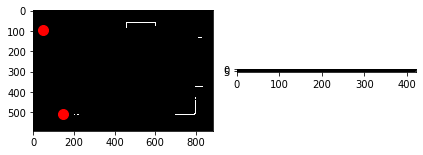

0.009456264775413711


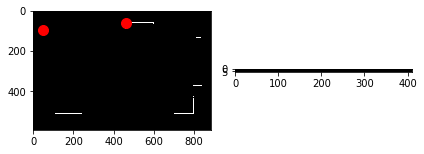

0.007281553398058253


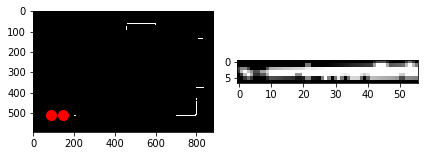

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


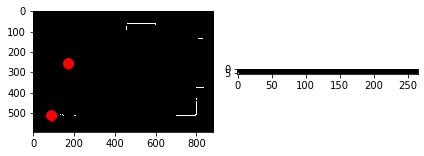

0.011320754716981131


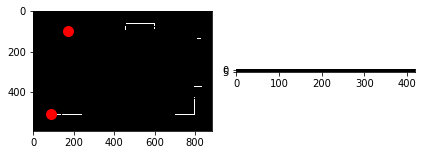

0.007177033492822967


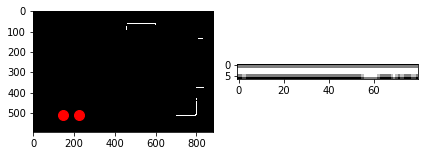

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


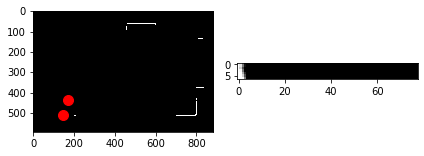

0.05128205128205128


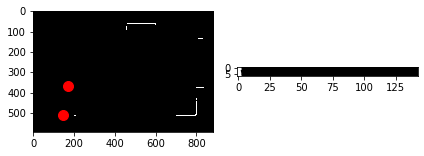

0.027972027972027972


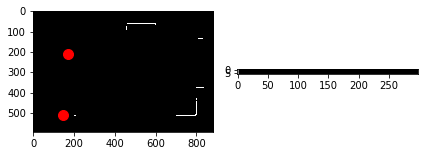

0.013422818791946308


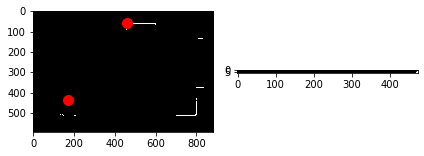

0.019027484143763214


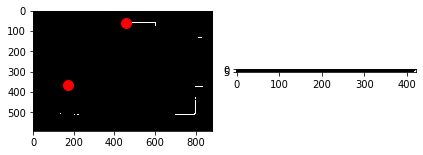

0.0166270783847981


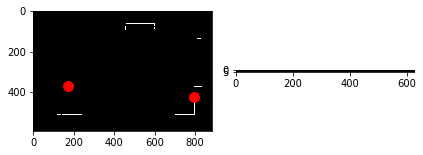

0.001597444089456869


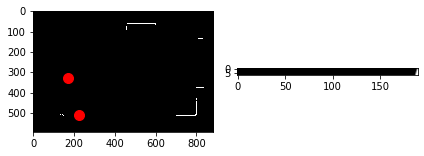

0.021052631578947368


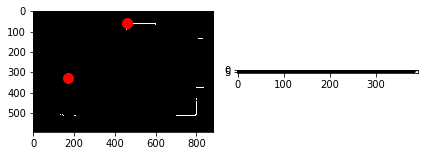

0.017857142857142856


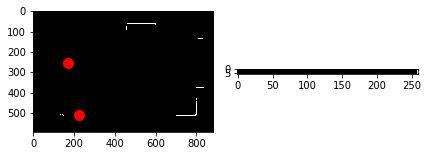

0.007722007722007722


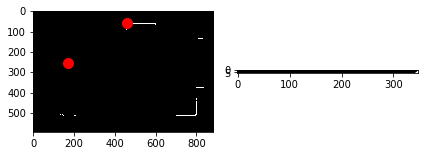

0.01440922190201729


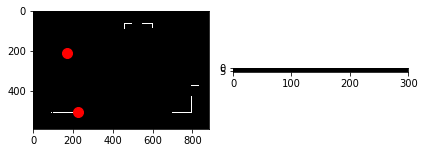

0.006644518272425249


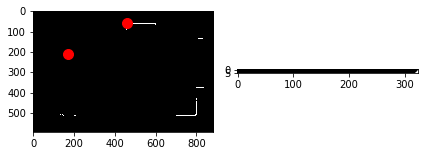

0.018518518518518517


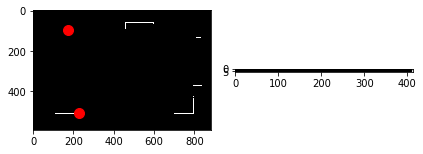

0.007246376811594203


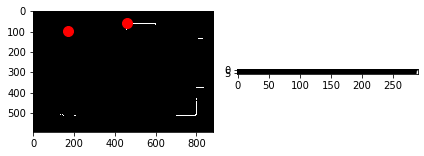

0.010344827586206896


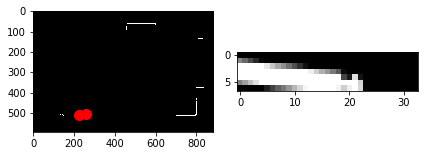

0.696969696969697


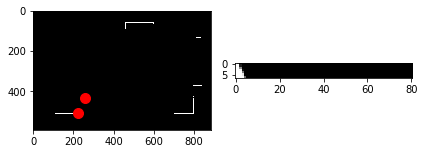

0.06172839506172839


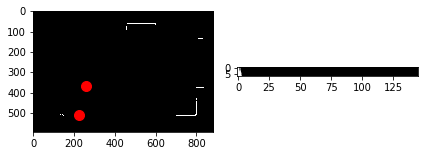

0.027586206896551724


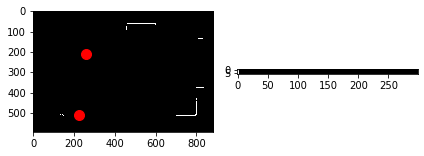

0.013377926421404682


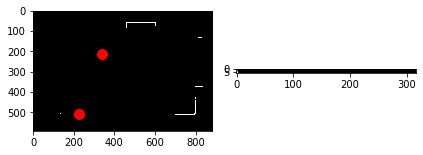

0.015822784810126583


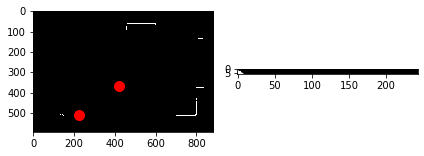

0.037037037037037035


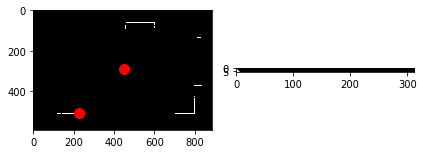

0.022364217252396165


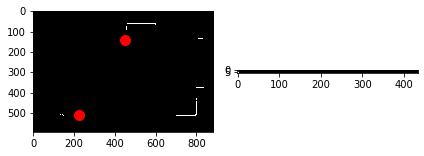

0.013856812933025405


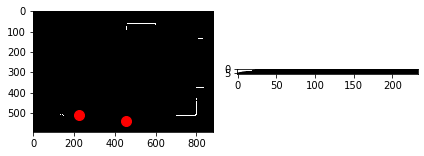

0.09871244635193133


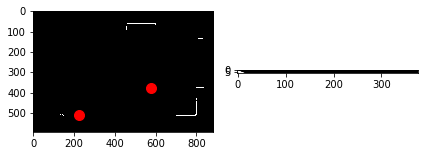

0.0425531914893617


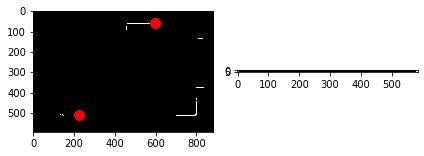

0.023972602739726026


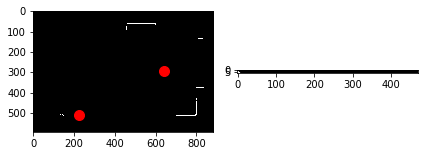

0.02553191489361702


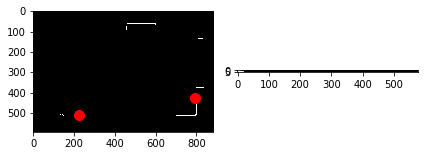

0.043402777777777776


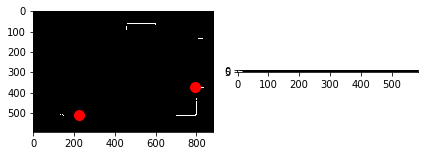

0.039316239316239315


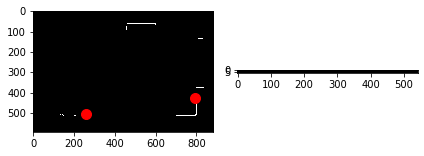

0.0018450184501845018


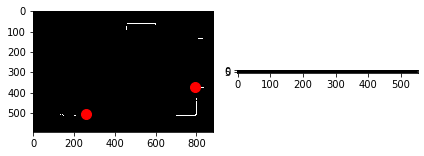

0.0036231884057971015


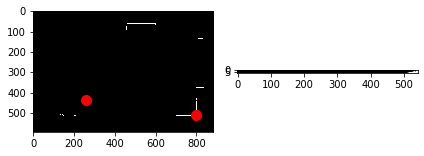

0.07380073800738007


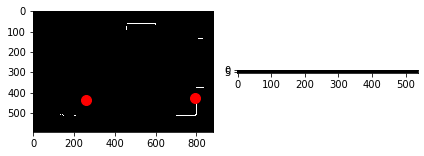

0.0018656716417910447


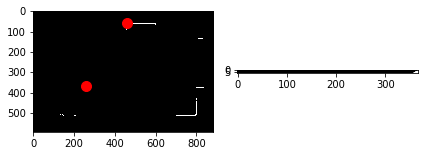

0.030054644808743168


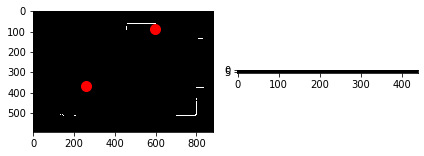

0.00228310502283105


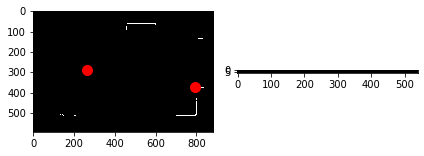

0.0018552875695732839


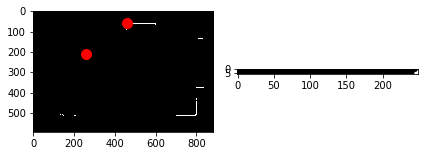

0.020080321285140562


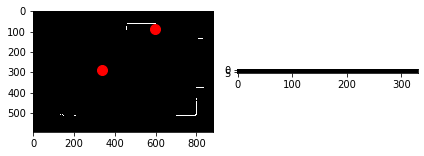

0.0030303030303030303


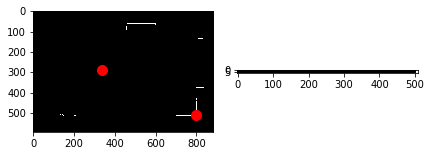

0.023622047244094488


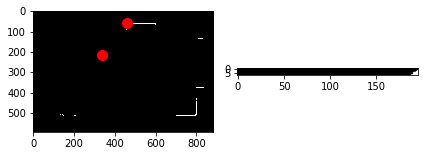

0.041025641025641026


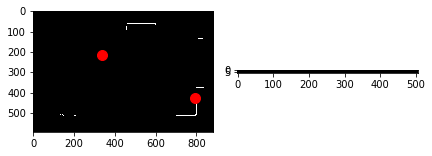

0.0019801980198019802


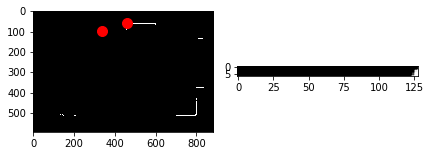

0.0390625


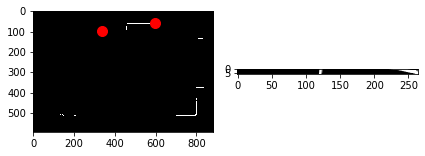

0.1893939393939394


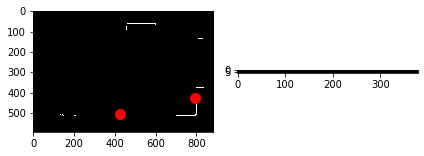

0.002638522427440633


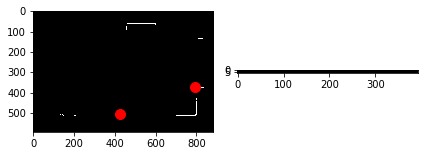

0.002544529262086514


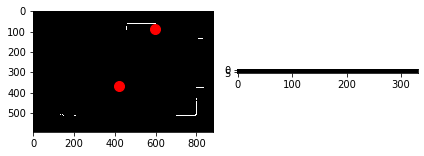

0.0030211480362537764


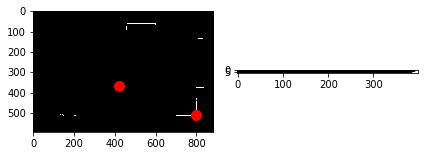

0.03768844221105527


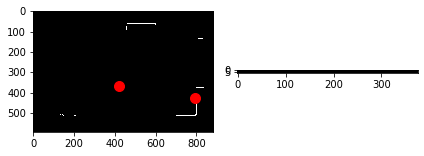

0.0026595744680851063


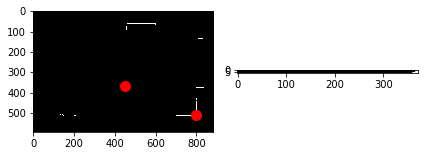

0.03504043126684636


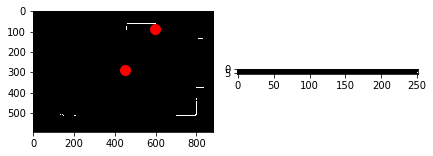

0.00398406374501992


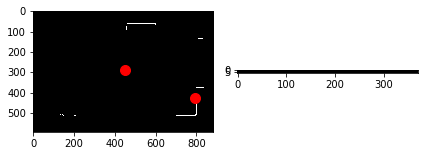

0.002702702702702703


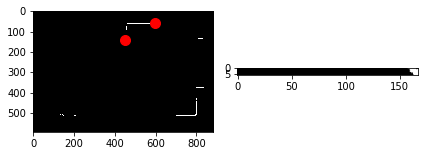

0.0718562874251497


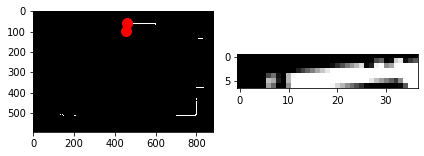

0.8108108108108109
c2 - c1: 83.8298249049704, c1 - c2: 263.8298249049704
{263.8298249049704}


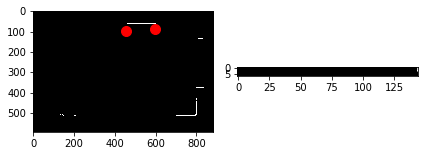

0.006944444444444444


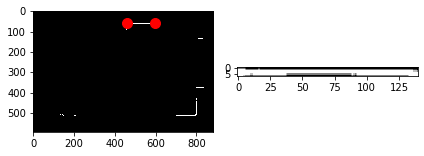

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


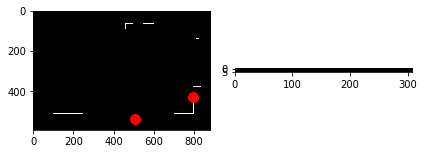

0.006493506493506494


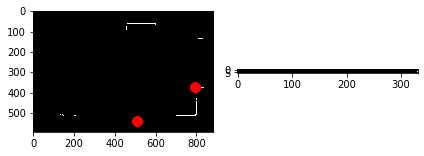

0.006042296072507553


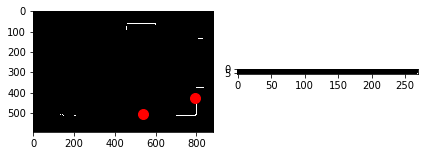

0.0037174721189591076


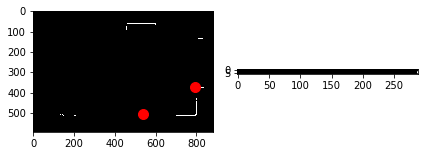

0.006944444444444444


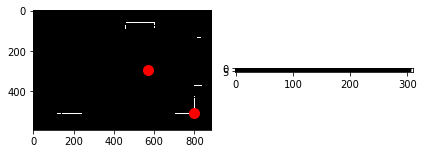

0.022508038585209004


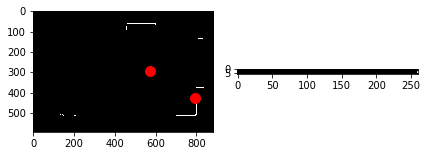

0.0038461538461538464


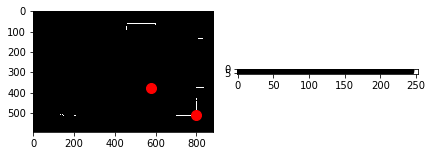

0.03162055335968379


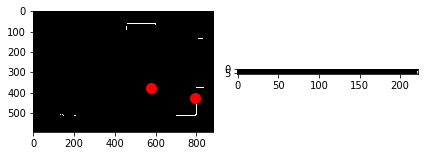

0.009009009009009009


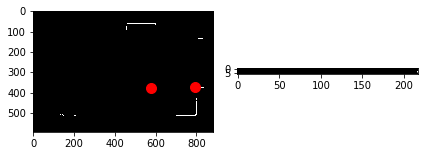

0.004608294930875576


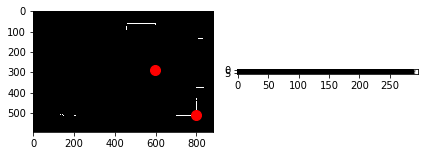

0.02702702702702703


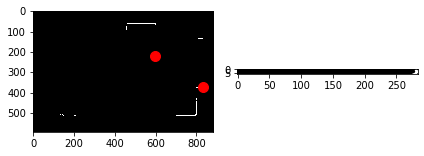

0.035211267605633804


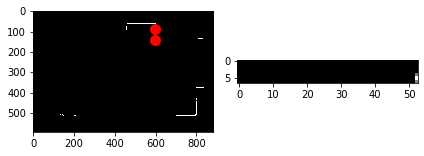

0.018867924528301886


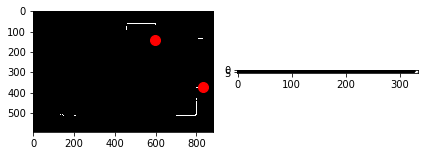

0.020958083832335328


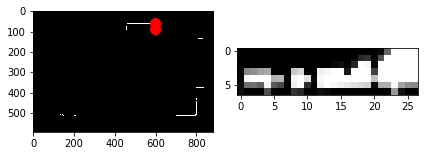

1.0
c2 - c1: 90.0, c1 - c2: 270.0
{180.0, 270.0}


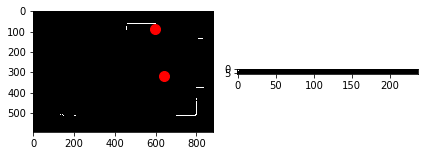

0.012658227848101266


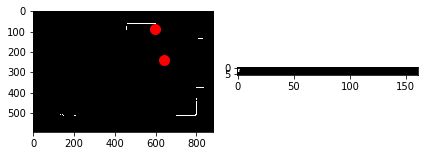

0.018633540372670808


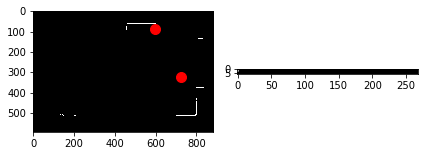

0.014925373134328358


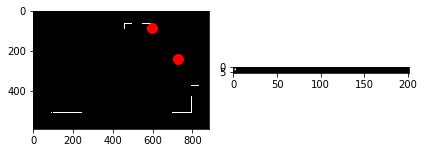

0.014925373134328358


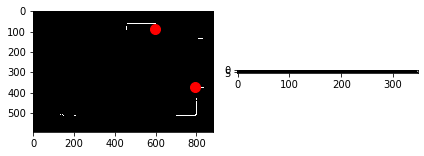

0.020114942528735632


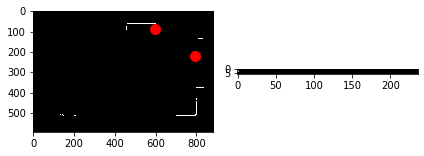

0.01694915254237288


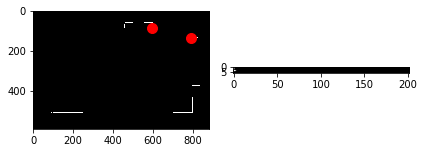

0.019801980198019802


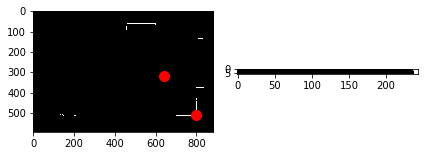

0.03292181069958848


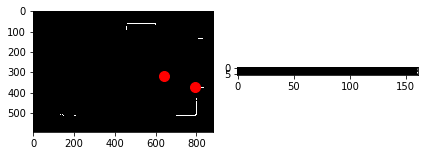

0.006211180124223602


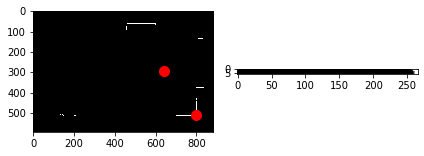

0.03759398496240601


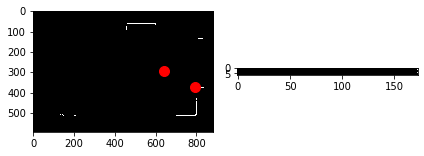

0.005780346820809248


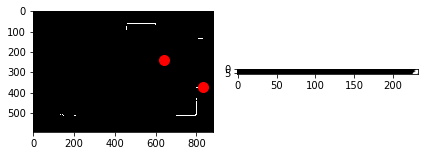

0.034482758620689655


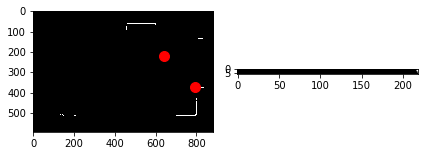

0.013761467889908258


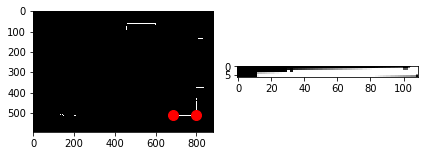

0.8899082568807339
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


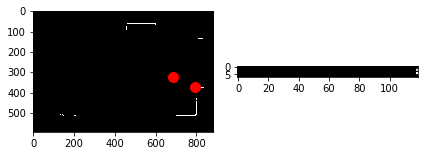

0.008403361344537815


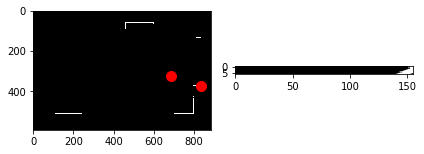

0.0967741935483871


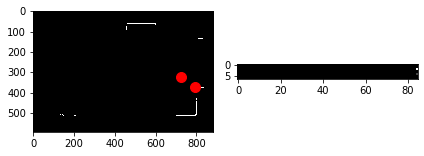

0.011764705882352941


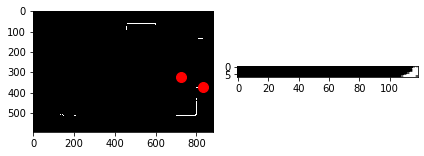

0.09243697478991597


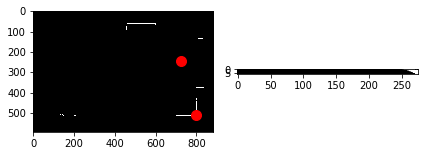

0.08727272727272728


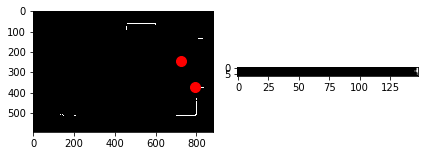

0.02027027027027027


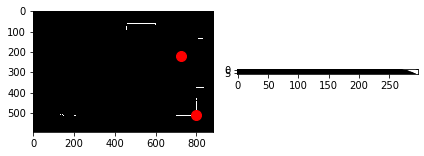

0.08754208754208755


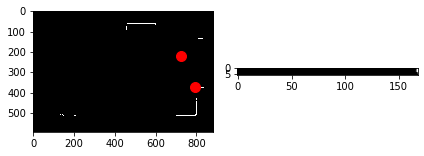

0.017857142857142856


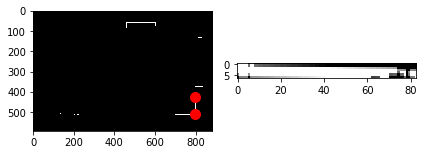

0.9879518072289156
c2 - c1: 90.0, c1 - c2: 270.0
{270.0}


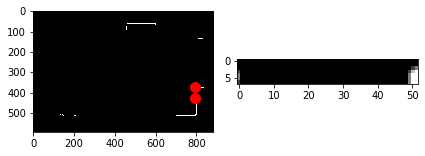

0.07692307692307693


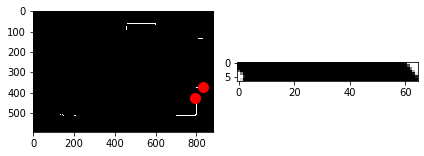

0.12307692307692308


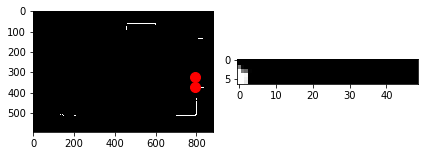

0.08163265306122448


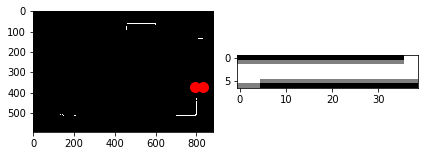

1.0
c2 - c1: 0.0, c1 - c2: 180.0
{180.0}


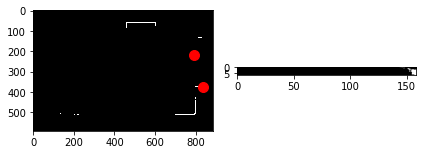

0.0880503144654088


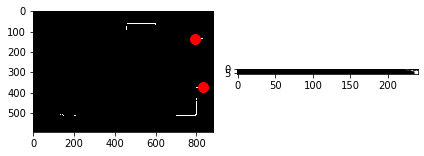

0.10833333333333334


In [8]:

railings = get_walls(heatmaps, railing_pixels, multiply_maps=False)
railings = tuple({'points': r} for r in railings)

In [ ]:
doors = get_opening_bb(doors_pixels, kernel_size=(2,2))
doors = tuple({'points': d, 'type': 'door'} for d in doors)

In [ ]:
def attach_openings(walls, elements, verbose=False):
    '''
        Changes walls destructively.
    '''

    elements = set([HashableDict(e) for e in elements])
    for wall in walls:
        elements_to_remove = []
        wall_segment = wall['points']

        for element in elements:
            perpendicular_element = element_segment(element['points'])
            element['perp'] = perpendicular_element

            if intersect(wall_segment, perpendicular_element):
                elements_to_remove.append(element)
                if 'elements' not in wall:
                    wall['elements'] = []

                wall['elements'].append(element.value)

        for element in elements_to_remove:
            elements.remove(element)

    return walls

In [ ]:
attach_openings(walls, doors)

In [ ]:
def show_img(im, walls=None, railings=None, elements=None):
    if walls:
        for w in walls:
            s, e = w['points'][0], w['points'][1]
            im = cv2.line(im, np.intp(s), np.intp(e), color=(200, 130, 0), thickness=2)
            im = cv2.circle(im, np.intp(s), color=(255, 0, 0), radius=5, thickness=2)
            im = cv2.circle(im, np.intp(e), color=(255, 0, 0), radius=5, thickness=2)

    if railings:
        for r in railings:
            s, e = r['points'][0], r['points'][1]
            im = cv2.line(im, np.intp(s), np.intp(e), color=(130, 200, 0), thickness=2)
            im = cv2.circle(im, np.intp(s), color=(255, 0, 0), radius=3, thickness=2)
            im = cv2.circle(im, np.intp(e), color=(255, 0, 0), radius=3, thickness=2)

    if elements:
        for el in elements:
            s, e = el['points'][0], el['points'][1]
            ps, pe = el['perp'][0], el['perp'][1]

            color = (0, 255, 0) if el['type'] == 'window' else (0, 0, 255)
            pcolor = (50, 50, 210) if el['type'] == 'window' else (50, 210, 50) 
            im = cv2.line(im, np.intp(s), np.intp(e), color=color, thickness=2)
            im = cv2.line(im, np.intp(ps), np.intp(pe), color=pcolor, thickness=2)

    plt.figure(figsize=(10,10))
    plt.imshow(im)
    
# reconstr = np.copy(original)
# reconstr = np.full(original.shape, 255).astype(np.uint8)
# for wall in walls:
#     s, e = wall
#     reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (66, 66, 66), 3)

# for wall in walls:
#     s, e = wall
#     reconstr = cv2.circle(reconstr, np.intp(s), 3, (91, 93, 91), 3)
#     reconstr = cv2.circle(reconstr, np.intp(e), 3, (91, 93, 91), 3)

# plt.figure(figsize=(12,12))
# plt.axis('off')
# plt.imshow(reconstr)
show_img(original, walls=walls, railings=railings, elements=doors)

In [ ]:


show_img(walls_closed, walls)

In [ ]:
doors = get_opening_bb(doors_pixels)
doors = tuple({'points': d, 'type': 'door'} for d in doors)
# FIXME: classify door as to be run after attaching to walls

windows = get_opening_bb(windows_pixels)
windows = tuple({'points': w, 'type': 'window'} for w in windows)


In [ ]:
elements = tuple(el for el in doors + windows if np.linalg.norm(vector(el['points'])) > 10) 
print(len(elements))


In [ ]:
element_lines =  tuple({**e, 'perp': element_segment(e['points'])} for e in elements)
# element_lines =  tuple({**e, 'perp': e['points']} for e in doors + windows)
print(element_lines[0])
show_img(walls_closed, walls, element_lines)

In [ ]:
walls = attach_openings(walls, elements, True)
walls

In [ ]:
walls = normalize_wall_points(walls, 5)
show_img(walls_closed, walls, element_lines)

In [ ]:
from door_classification import crop_door

for wall in walls:
    if 'elements' in wall:
        print(wall['elements'])
        for element in wall['elements']:
            if element['type'] != 'window':
                print('='*50)

                orig_img = original.copy()
                orig_img = cv2.circle(orig_img, np.intp(element['points'][0]), 4, (255, 0, 0,), 4)
                orig_img = cv2.circle(orig_img, np.intp(wall['points'][0]), 4, (0, 255, 0,), 4)
                plt.imshow(orig_img)
                plt.show()

                cropped_door = crop_door(element, wall, original)
                plt.imshow(cropped_door)
                plt.show()

                element['type'] = classify_door(element, wall, original)
                print(element['type'])

# Just call main

In [ ]:
from recognition import *
import matplotlib.pyplot as plt

In [ ]:
results = main('01_Ground_floor_plan.png')
results

In [ ]:
original = cv2.imread('01_Ground_floor_plan.png')
im = np.full(original.shape, 255).astype(np.uint8)

In [ ]:
reconstr = im.copy()
for wall in results['walls']:
    s, e = wall['points']
    reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (0, 0, 0), 3)

    if 'elements'  in wall:
        for el in wall['elements']:
            s, e = el['points']
            if el['type'] == 'window':
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (147, 181, 198), 3)
            else:
                reconstr = cv2.line(reconstr, np.intp(s), np.intp(e), (94, 80, 63), 3)
                reconstr = cv2.putText(
                    reconstr, el['type'][-2:],
                    np.intp(s),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (230, 80, 63), 1, 2
                )

icons = ('closet', 'toilet', 'sink', 'bathtub')
colors = ((145, 91, 36), (133, 218, 255),  (58, 126, 156), (201, 30, 173))
for icon in results['icons']:
    # pts = np.intp(icon['points'])
    # print(pts, pts.shape, pts.reshape((-1, 1, 2)))
    reconstr = cv2.drawContours(reconstr, [np.intp(icon['points'])], 0, colors[icons.index(icon['type'])], 3)

plt.figure(figsize=(15, 15))
plt.imshow(original)

plt.figure(figsize=(15, 15))
plt.imshow(reconstr)
plt.show()